In [1]:
import pandas as pd
import numpy as np

In [2]:
#Load dataset
df = pd.read_csv('lyrics.csv', encoding = 'ISO-8859-1')

#Clean data: remove newlines, NAN-values and lyrics with to low/high word count,
#also remove the "Not Available" genre.
def clean_data(df):
    df = df.replace({'\n': ' '}, regex=True)
    df.dropna()
    
    indexNames = df[df['genre'] == "Not Available"].index
    df.drop(indexNames, inplace=True)
    
    df['word_count'] = df['lyrics'].str.split().str.len()
    df = df[df['word_count'] != 1]
    df = df[df['word_count'] >= 100]
    df = df[df['word_count'] <= 1000]   
    return df

#Now this is good data...
df = clean_data(df)

#Check contents of dataframe
df.sample(n=10)
print(len(df))

208770


Now we look more closely on the lyrics column and preprocess the string data with spacy. 
Preprocessing consists of Tokenization, stop word removal, and lemmatization of words. 

In [3]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer 

# Import only relevant modules 
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

#These words are in all lyrics
structure_words = ["intro", "verse", "bridge", "outro"]

# Tokenization, stop word removal, and lemmatization.
def preprocess(text):
    doc = nlp(text)
    output = []
    for token in doc:
        if not token.is_stop and token.text:
            if token.lemma_.isalpha() and token.lemma_ not in structure_words:
                output.append(token.lemma_.lower())
    return output

To understand the dataset better we create some plots for visualization.

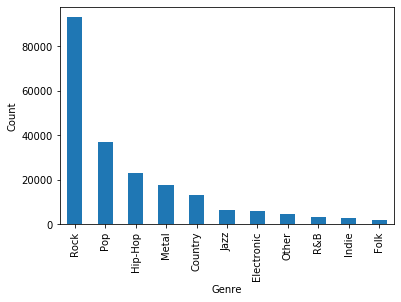

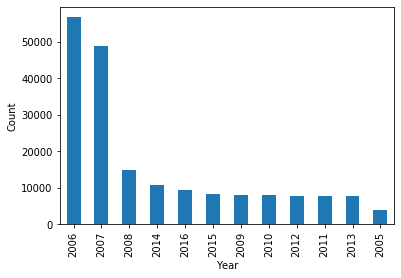

,index,song,year,artist,genre,lyrics,word_count
14611,14611,dreaming,2007,fools-garden,Rock,Dreaming. It's not that easy any more when you...,256.0
25369,25369,winds-of-change,2006,cinderella,Rock,I look into the mirror Can almost count the ye...,263.0
122355,122355,four-walls,2006,cheyenne-kimball,Rock,These four walls They whisper to me They know ...,139.0
323202,323202,louis-loon,2008,barenaked-ladies,Rock,Dive down Into the cool green water Swim aroun...,129.0
252814,252814,individuo,2007,breed-77,Metal,How much do you think you know? The truth hide...,126.0
106421,106421,don-t-ask-me-why,2006,eleanor-mcevoy,Folk,Lying here naked with me Can you see Tears tha...,119.0
104096,104096,this-ain-t-no-rag-it-s-a-flag,2007,charlie-daniels-band,Rock,"This ain't no rag, it's a flag And we don't we...",410.0
91139,91139,as-country-as-she-gets,2015,dean-brody,Country,SHE HATES GOING ANYWHERE IN MY OLD TRUCK SHE S...,154.0
77734,77734,trail-of-blood,2007,gehenna,Metal,Strapped down to the table Unable to move Face...,115.0
285361,285361,dare-i-say,2006,bran-van-3000,Rock,Hey Job You sure got it figured out She loves ...,336.0


In [11]:
import matplotlib.pyplot as plt

genre_count = df['genre'].value_counts()
year_count = df['year'].value_counts().head(12)

genre_count.plot.bar()
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

year_count.plot.bar()
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

df.sample(n=10)

We start genre classification by dividing data into training and test datasets. 

In [8]:
from sklearn.model_selection import train_test_split

#Split data into training and test datasets
train, test = train_test_split(df, test_size=0.1)
print(len(train))
print(len(test))

#Create a vectorizer for lyrics
v = TfidfVectorizer(tokenizer = preprocess)
genres = sorted(df["genre"].unique())

187893
20877


1) Here we implement a random baseline, that generates random predictions, where the probability of a class is determined by its relative frequency in the training data. This functionality is provided by scikit-learn’s DummyClassifier. 

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

dummy_classifier = DummyClassifier(strategy="stratified")

print("Prediction with random baseline:\n")
dummy_classifier.fit(train["lyrics"], train["genre"]) 
predictions = dummy_classifier.predict(test["lyrics"])

# Confusion matrix
print('Generating Confusion Matrix...\n')
conf = confusion_matrix(test["genre"], predictions)
np.savetxt("confusion_matrix_dummy.csv", conf, fmt='%i', delimiter=",")

# Classification report
print('Classification Report')
print(classification_report(test["genre"], predictions))

Prediction with random baseline:

Generating Confusion Matrix...

Classification Report
              precision    recall  f1-score   support

     Country       0.06      0.06      0.06      1274
  Electronic       0.04      0.04      0.04       594
        Folk       0.00      0.00      0.00       181
     Hip-Hop       0.12      0.11      0.12      2371
       Indie       0.01      0.01      0.01       262
        Jazz       0.02      0.02      0.02       637
       Metal       0.09      0.09      0.09      1801
       Other       0.03      0.03      0.03       453
         Pop       0.18      0.18      0.18      3747
         R&B       0.02      0.02      0.02       323
        Rock       0.44      0.45      0.44      9234

    accuracy                           0.26     20877
   macro avg       0.09      0.09      0.09     20877
weighted avg       0.25      0.26      0.26     20877

Accuracy on test data: 25.6%


2) Here we implement classification with Logistic regression:

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Choose if you want to run the classifier from here! Maybe you only want to print results,
# it takes quite a while...
RUN=True

#Here lay the pipes
if (RUN):
    pipe_lr = Pipeline([('vect', v),
                        ('clf', LogisticRegression())])
    print("\nPrediction based on logistic regression...\n")
    pipe_lr.fit(train["lyrics"].values.astype('U'), train["genre"])
    predictions = pipe_lr.predict(test["lyrics"].values.astype('U'))

# Confusion matrix
print('Generating Confusion Matrix...')
conf = confusion_matrix(test["genre"], predictions)
np.savetxt("confusion_matrix_logreg.csv", conf, fmt='%i', delimiter=",")

# Classification report
print('Classification Report')
print(classification_report(test["genre"], predictions))


Prediction based on logistic regression...



/courses/TDDE16/labs/environment/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/courses/TDDE16/labs/environment/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Generating Confusion Matrix...
Classification Report
              precision    recall  f1-score   support

     Country       0.55      0.20      0.30      1274
  Electronic       0.67      0.01      0.03       594
        Folk       0.89      0.04      0.08       181
     Hip-Hop       0.84      0.75      0.79      2371
       Indie       1.00      0.00      0.01       262
        Jazz       0.51      0.10      0.17       637
       Metal       0.77      0.52      0.62      1801
       Other       0.34      0.03      0.05       453
         Pop       0.50      0.34      0.40      3747
         R&B       1.00      0.03      0.05       323
        Rock       0.58      0.89      0.70      9234

    accuracy                           0.60     20877
   macro avg       0.69      0.27      0.29     20877
weighted avg       0.62      0.60      0.55     20877

Accuracy on test data: 60.3%


3) Here we implement classification with Multinominal Naive Bayes:

In [17]:
from sklearn.naive_bayes import MultinomialNB

# Choose if you want to run the classifier from here! Maybe you only want to print results,
# it takes quite a while...
RUN=True

#Here lay the pipes
if (RUN):
    pipe_mnb = Pipeline([('vect', v),
                        ('clf', MultinomialNB())])
    print("\nPrediction based on multinominal-nb...\n")
    pipe_mnb.fit(train["lyrics"].values.astype('U'), train["genre"])
    predictions = pipe_mnb.predict(test["lyrics"].values.astype('U'))

# Confusion matrix
print('Generating Confusion Matrix...')
conf = confusion_matrix(test["genre"], predictions)
np.savetxt("confusion_matrix_mnb.csv", conf, fmt='%i', delimiter=",")

# Classification report
print('Classification Report')
print(classification_report(test["genre"], predictions))


Prediction based on multinominal nb...

Generating Confusion Matrix...
Classification Report


/courses/TDDE16/labs/environment/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     Country       0.00      0.00      0.00      1274
  Electronic       0.00      0.00      0.00       594
        Folk       0.83      0.03      0.05       181
     Hip-Hop       0.89      0.45      0.60      2371
       Indie       0.00      0.00      0.00       262
        Jazz       0.00      0.00      0.00       637
       Metal       0.98      0.05      0.09      1801
       Other       0.00      0.00      0.00       453
         Pop       0.42      0.13      0.19      3747
         R&B       0.00      0.00      0.00       323
        Rock       0.48      0.96      0.64      9234

    accuracy                           0.50     20877
   macro avg       0.33      0.15      0.14     20877
weighted avg       0.48      0.50      0.40     20877



4) Since M-nb underwhelms in terms of performance we check if we can improve the 
results with grid search for paramater tuning.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

# Choose if you want to run the classifier from here! Maybe you only want to print results,
# it takes A VERY long time. Do not run if you do not have much time on your hands!
RUN=False

#Here lay the pipes
if (RUN):
    pipe_mnb2 = Pipeline([('vect', CountVectorizer(binary=True)),
                        ('clf', MultinomialNB())])

    print("\nInitiating grid search. This may take a while...")
    grid_params = {
        'vect__analyzer': ['char', 'word'],
        'vect__ngram_range': [(1, 1), (1, 2)],
        'clf__alpha': [1, 0.1]
        }

    clf = GridSearchCV(pipe_mnb2, grid_params, cv=5)
    clf.fit(df["lyrics"], df["genre"])
    print("\nBest Score: ", clf.best_score_)
    print("Best Params: ", clf.best_params_)
    # Predict
    print("\nPrediction using best parameters from grid search on mnb2:\n")
    predictions = clf.predict(test["lyrics"])

# Confusion matrix
print('Generating Confusion Matrix...')
conf = confusion_matrix(test["genre"], predictions)
np.savetxt("confusion_matrix_mnb.csv", conf, fmt='%i', delimiter=",")

# Report
print(classification_report(test["genre"], predictions))


Initiating grid search. This may take a while...

Best Score:  0.5831297600229918
Best Params:  {'clf__alpha': 0.1, 'vect__analyzer': 'word', 'vect__ngram_range': (1, 2)}

Prediction using best parameters from grid search on mnb2:

Generating Confusion Matrix...
              precision    recall  f1-score   support

     Country       0.81      0.95      0.87      1274
  Electronic       0.97      0.76      0.85       594
        Folk       0.70      0.63      0.66       181
     Hip-Hop       0.97      0.87      0.92      2371
       Indie       1.00      0.63      0.77       262
        Jazz       0.72      0.79      0.76       637
       Metal       0.92      0.90      0.91      1801
       Other       0.41      0.54      0.47       453
         Pop       0.87      0.90      0.89      3747
         R&B       0.94      0.70      0.80       323
        Rock       0.91      0.91      0.91      9234

    accuracy                           0.88     20877
   macro avg       0.84      0.7

Classification is done move on to second file for hit song correlation with topic models.